In [1]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score

## K-means clustering & V-measure

### Configuration

In [2]:
output_dir = './latent_outputs'
streams = {'residual': 'r', 'mlp': 'm', 'attention': 'a'}
layers = range(15, 32)
corpora = ['nontemporal', 'temporal']
labels = ['past', 'present', 'future']
n_clusters = len(labels)

## 1. Compute v‑measure v_ℓ at each layer ℓ for both corpora

- Llama Scope

In [3]:
def compute_v_measure():
    results = []
    
    for corpus in corpora:
        for stream_name, stream_code in streams.items():
            for layer in layers:
                # Collect feature activations and true labels
                feats_list = []
                true_labels = []
                for label in labels:
                    feat_path = os.path.join(
                        output_dir,
                        f'{corpus}_{label}_l{layer}_{stream_name}_feature_acts.pt'
                    )
                    meta_path = os.path.join(
                        output_dir,
                        f'{corpus}_{label}_l{layer}_{stream_name}_metadata.parquet'
                    )
                    if not (os.path.exists(feat_path) and os.path.exists(meta_path)):
                        continue
                    feat = torch.load(feat_path).float()           # shape [N, F]
                    df_meta = pd.read_parquet(meta_path)   # contains 'tense'
                    feats_list.append(feat.reshape(feat.shape[0], -1).numpy())
                    true_labels.extend(df_meta['tense'].tolist())
                if not feats_list:
                    continue
                X = np.vstack(feats_list)
                y_true = true_labels

                # K‑means clustering
                km = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
                y_pred = km.fit_predict(X)

                # v‑measure: \(v = 2 \times \frac{h \cdot c}{h + c}\)
                v = v_measure_score(y_true, y_pred)

                results.append({
                    'corpus': corpus,
                    'stream': stream_name,
                    'layer': layer,
                    'v_measure': v
                })
                
    return results

In [4]:
# Aggregate into DataFrame and save
results = compute_v_measure()

df_v = pd.DataFrame(results)
df_v.to_csv(os.path.join('./v_measure_by_layer_llamascope.csv'), index=False)

- Translation

In [4]:
output_dir = './latent_outputs_yusser'

# Aggregate into DataFrame and save
results = compute_v_measure()

df_v = pd.DataFrame(results)
df_v.to_csv(os.path.join('./v_measure_by_layer_translation.csv'), index=False)

#### Visualization

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [4]:
# 1. Load & tag
df_ls = pd.read_csv('./v_measure_by_layer_llamascope.csv')
df_ls['sae'] = 'llamascope'
df_tr = pd.read_csv('./v_measure_by_layer_translation.csv')
df_tr['sae'] = 'translation'

In [5]:
# 2. Combine
df = pd.concat([df_ls, df_tr], ignore_index=True)

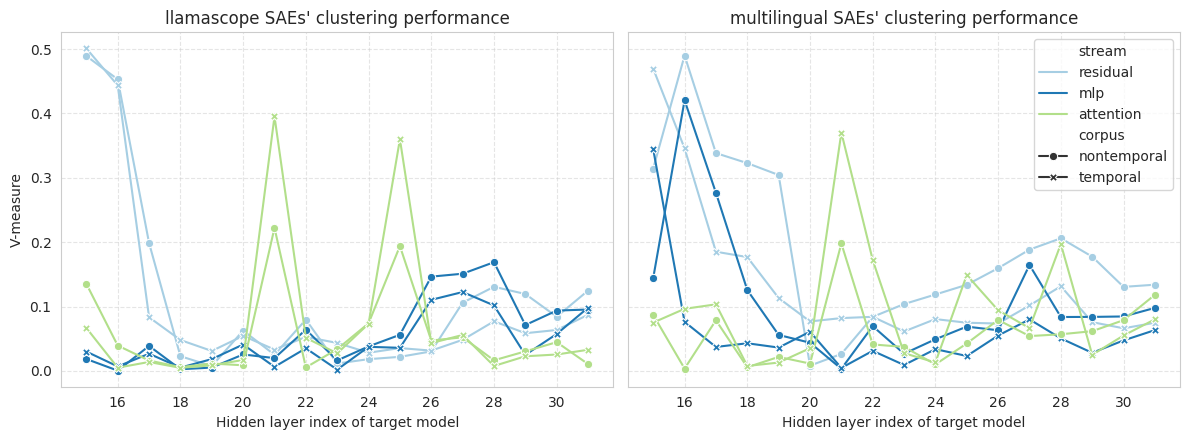

In [6]:
# 3. Plot side‑by‑side
sns.set_style("whitegrid", {"grid.linestyle": "--"})
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)

for ax, sae in zip(axes, ['llamascope', 'translation']):
    sub = df[df['sae'] == sae]
    sns.lineplot(
        data=sub,
        x='layer',
        y='v_measure',
        hue='stream',
        style='corpus',
        palette='Paired',
        linewidth=1.5,
        markers=True,
        dashes=False,
        legend=(sae == 'translation'),
        ax=ax
    )
    sae_name = sae if sae == 'llamascope' else 'multilingual'
    ax.set_title(f"{sae_name} SAEs' clustering performance")
    ax.set_xlabel("Hidden layer index of target model")
    if ax is axes[0]:
        ax.set_ylabel("V‑measure")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True, linestyle='--', alpha=0.5)

# Move legend outside right of the second plot
# axes[1].legend(title='stream / corpus', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

plt.tight_layout()
plt.show()